# Introduction

[RSGISLib](http://rsgislib.org) has a number image classification modules which allow both pixel and segment (object / clump) based classifications using various machine learning algorithms and libraries.

In this tutorial we will go through the key steps in performing a per-pixel machine learning classification using the [Scikit-Learn](https://scikit-learn.org) library which has many different classification algorithms implemented but also regression algorithms (see other tutorials).

The steps included in this tutorial are:

 * Defining sample data
 * Extract sample data
 * Balance sample data and create training and testing subsets
 * Train classifier
 * Apply classifier



## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_



# 1. Import modules

In [49]:
import rsgislib
import rsgislib.classification
import rsgislib.vectorutils
import rsgislib.zonalstats
import rsgislib.tools.filetools

import geopandas

import os
import pprint

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import random

# Import the RSGISLib plotting module which has functions for helping
# to read and visualise image data within a plot for visualisation 
# within a notebook.
import rsgislib.tools.plotting

## 1.1 Define the input image files

The input images files are defined:

In [12]:
# Input Sentinel-2 image file with 20 m resolution pixels.
input_img = "../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif"

# A valid pixel mask for the input image - this is required for later
# steps but note that for this particular image all the pixel values
# are valid (i.e., there aren't are no data regions).
in_msk_img = "../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif"

# 2. Defining Training Samples

Samples are define using polygon or point vector layers, where each layer is defines a single class where multiple polygons/points are used to identify pixels belonging the the class of interest. It should be noted that the vector layer needs to be the same projection as the input image(s).

Samples are defined by either referencing an existing dataset or manually digitising regions using a desktop GIS. [QGIS](https://www.qgis.org) is freely available and easiest to access desktop GIS which can be used for this purpose but other desktop GIS packages (e.g., ArcGIS) are also available.

For this analysis the following Geopackage (GPKG) file as a number of layers defining the training data:


In [5]:
vec_train_file = "../data/cls_data/aber_sen2_cls_training.gpkg"

## 2.1 List the vector layers

To find out which layers are within the vector layer and therefore the classes training data has been provided for this analysis:


In [10]:
# Get the list of layers within the vector file.
lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(vec_train_file)

# Print out the layer names by looping through the list of layers returned.
# Note. the enumerate function returns the array index and the list value:
for i, lyr_name in enumerate(lyr_names):
    print(f"{i+1}:\t{lyr_name}")

1:	Artificial_Surfaces
2:	Bare_Rock_Sand
3:	Conifer_Forest
4:	Deciduous_Forest
5:	Grass_Long
6:	Grass_Short
7:	NonPhotosynthetic_Vegetation
8:	Scrub
9:	Water_Training
10:	Bracken


## Visualise the training data

It is recommended that you open the input image (`sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif`) and training samples (`aber_sen2_cls_training.gpkg`) in QGIS (or equivlent) to see the regions which have been defined for training as this allows you to manipulate (i.e., pan and zoom) the data.

However, an overview visualisation is shown below for illustration. If you change the bounding box you can pan and zoom around scene.


In [15]:
# Get the full image bounding box.
img_bbox = rsgislib.imageutils.get_img_bbox(input_img)
print(img_bbox)

[249177.3321426216, 315077.3321426216, 268742.255157026, 326342.255157026]


Image Data Size: 1250 x 1250


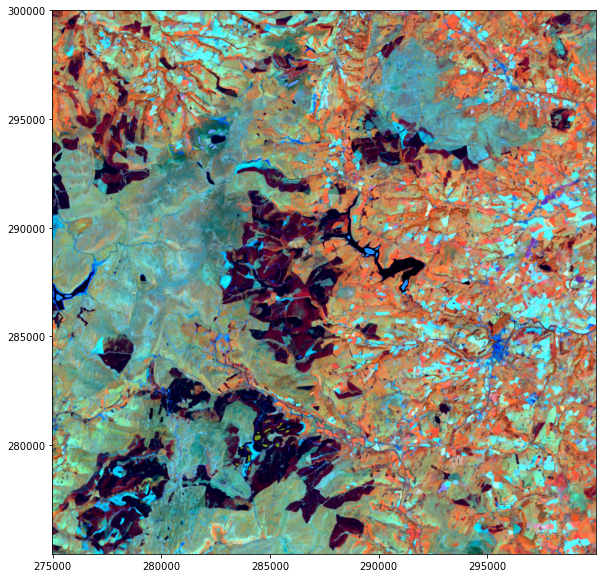

In [34]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [275000, 300000, 275000, 300000]

# Get the image data as a numpy array and the spatial bounding
# box of the image data. We have specified that the bands we 
# want for the visualisation are 8, 9, 3 (NIR, SWIR1, Red)
# which produces a good false colour visualisation which is 
# good at picking out vegetation. If you want a true colour
# (i.e., Red, Green, Blue) visualisation change the bands to
# [3, 2, 1]
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(input_img, 
                                                                          bands=[8,9,3], 
                                                                          bbox=sub_img_bbox)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Get a list of available colours within matplotlib
mpl_clrs = list(mcolors.CSS4_COLORS.keys())

for i, lyr_name in enumerate(lyr_names):
    # Read samples to geopandas dataframe
    smpls_gdf = geopandas.read_file(vec_train_file, layer=lyr_name)
    
    # Plot the samples over the image data with a random colour
    # Note. the colour for the classes will change each time
    # this code runs.
    smpls_gdf.plot(ax=ax, color=random.choice(mpl_clrs))

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

# 3. Extract Training Samples

For the analysis, individual pixel values are extracted and stored in a [HDF5](https://www.hdfgroup.org/solutions/hdf5/) which allows for that data to be stored and manipulated (e.g., pixels values from multiple images can be merged).

To extract the training samples (i.e., individual pixel values) using the defined vector layer the vector layers first need to be rasterised to the same pixel grid as the input image(s). To simplify the implementation of this a helper function has been provided: `rsgislib.classification.get_class_training_data`. This tutorial will therefore make use of this helper function.




## 3.1 Define Images and Bands for Classification

Before the image pixel values can be extracted or the classification performed the relevant images and bands within those images need to be defined. Clearly, these need to defined identically for both extracting the image samples and the classification step. If these are not identically defined then the trained classifer will not work as intended which is likely to produce very poor classification results.

To define the images and bands a list of `rsgislib.imageutils.ImageBandInfo` objects is provided to the relevant RSGISLib functions:


In [35]:
img_band_info = list()
img_band_info.append(rsgislib.imageutils.ImageBandInfo(file_name=input_img, name="sen2", bands=[1,2,3,4,5,6,7,8,9,10]))

## 3.2 Define the classes and the vector samples

For the helper function the class names and vector layers needed to be define as a list of `rsgislib.classification.ClassVecSamplesInfoObj` objects:

> Note. the `id` will be the output pixel value for the class in the output image.


In [39]:
class_vec_sample_info = list()

# Define the file name of the samples HDF5 file, which will be created
artificial_surfaces_h5 = "artificial_surfaces_smpls.h5"
class_vec_sample_info.append(rsgislib.classification.ClassVecSamplesInfoObj(id=1, 
                                                                            class_name="artificial_surfaces", 
                                                                            vec_file=vec_train_file, 
                                                                            vec_lyr="Artificial_Surfaces", 
                                                                            file_h5=artificial_surfaces_h5))

# Define the file name of the samples HDF5 file, which will be created
bare_rock_sand_h5 = "bare_rock_sand_smpls.h5"
class_vec_sample_info.append(rsgislib.classification.ClassVecSamplesInfoObj(id=2, 
                                                                            class_name="bare_rock_sand", 
                                                                            vec_file=vec_train_file, 
                                                                            vec_lyr="Bare_Rock_Sand", 
                                                                            file_h5=bare_rock_sand_h5))


# Define the file name of the samples HDF5 file, which will be created
conifer_forest_h5 = "conifer_forest_smpls.h5"
class_vec_sample_info.append(rsgislib.classification.ClassVecSamplesInfoObj(id=3, 
                                                                            class_name="conifer_forest", 
                                                                            vec_file=vec_train_file, 
                                                                            vec_lyr="Conifer_Forest", 
                                                                            file_h5=conifer_forest_h5))

# Define the file name of the samples HDF5 file, which will be created
deciduous_forest_h5 = "deciduous_forest_smpls.h5"
class_vec_sample_info.append(rsgislib.classification.ClassVecSamplesInfoObj(id=4, 
                                                                            class_name="deciduous_forest", 
                                                                            vec_file=vec_train_file, 
                                                                            vec_lyr="Deciduous_Forest", 
                                                                            file_h5=deciduous_forest_h5))

# Define the file name of the samples HDF5 file, which will be created
grass_long_h5 = "grass_long_smpls.h5"
class_vec_sample_info.append(rsgislib.classification.ClassVecSamplesInfoObj(id=5, 
                                                                            class_name="grass_long", 
                                                                            vec_file=vec_train_file, 
                                                                            vec_lyr="Grass_Long", 
                                                                            file_h5=grass_long_h5))

# Define the file name of the samples HDF5 file, which will be created
grass_short_h5 = "grass_short_smpls.h5"
class_vec_sample_info.append(rsgislib.classification.ClassVecSamplesInfoObj(id=6, 
                                                                            class_name="grass_short", 
                                                                            vec_file=vec_train_file, 
                                                                            vec_lyr="Grass_Short", 
                                                                            file_h5=grass_short_h5))

# Define the file name of the samples HDF5 file, which will be created
nonphoto_veg_h5 = "nonphoto_veg_smpls.h5"
class_vec_sample_info.append(rsgislib.classification.ClassVecSamplesInfoObj(id=7, 
                                                                            class_name="nonphoto_veg", 
                                                                            vec_file=vec_train_file, 
                                                                            vec_lyr="NonPhotosynthetic_Vegetation", 
                                                                            file_h5=nonphoto_veg_h5))

# Define the file name of the samples HDF5 file, which will be created
scrub_h5 = "scrub_smpls.h5"
class_vec_sample_info.append(rsgislib.classification.ClassVecSamplesInfoObj(id=8, 
                                                                            class_name="scrub", 
                                                                            vec_file=vec_train_file, 
                                                                            vec_lyr="Scrub", 
                                                                            file_h5=scrub_h5))

# Define the file name of the samples HDF5 file, which will be created
water_h5 = "water_smpls.h5"
class_vec_sample_info.append(rsgislib.classification.ClassVecSamplesInfoObj(id=9, 
                                                                            class_name="water", 
                                                                            vec_file=vec_train_file, 
                                                                            vec_lyr="Water_Training", 
                                                                            file_h5=water_h5))

# Define the file name of the samples HDF5 file, which will be created
bracken_h5 = "bracken_smpls.h5"
class_vec_sample_info.append(rsgislib.classification.ClassVecSamplesInfoObj(id=10, 
                                                                            class_name="bracken", 
                                                                            vec_file=vec_train_file, 
                                                                            vec_lyr="Bracken", 
                                                                            file_h5=bracken_h5))




## 3.3 Create a temporary output directory

The helper function requires a directory for temporary outputs (e.g., rastered vector layers) to be written to during the processing. The following code will test as to whether the directory already exists and if not it will created it:

In [37]:
tmp_dir = "./tmp"

if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

## 3.4 Perform Sample Extraction

The next step will now use the `rsgislib.classification.get_class_training_data` helper function to extract the sample data:


In [41]:
cls_smpls_info = rsgislib.classification.get_class_training_data(img_band_info, 
                                                                 class_vec_sample_info, 
                                                                 tmp_dir, 
                                                                 ref_img=in_msk_img)

Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Running Rasterise now...

Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Running Rasterise now...
Get Image Min and Max.

Creating output image using input imageGet Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




Running R

In [42]:
# Output the returned class samples info object - note the colours have been randomly assigned:
cls_smpls_info

{'artificial_surfaces': 1: artificial_surfaces_smpls.h5, (200, 248, 208),
 'bare_rock_sand': 2: bare_rock_sand_smpls.h5, (50, 65, 52),
 'conifer_forest': 3: conifer_forest_smpls.h5, (30, 161, 199),
 'deciduous_forest': 4: deciduous_forest_smpls.h5, (4, 228, 61),
 'grass_long': 5: grass_long_smpls.h5, (150, 36, 59),
 'grass_short': 6: grass_short_smpls.h5, (74, 159, 70),
 'nonphoto_veg': 7: nonphoto_veg_smpls.h5, (138, 19, 12),
 'scrub': 8: scrub_smpls.h5, (73, 89, 97),
 'water': 9: water_smpls.h5, (222, 33, 205),
 'bracken': 10: bracken_smpls.h5, (187, 106, 84)}

## 3.5 How many training samples were extracted:

To find out how many training samples were extracted the following code will loop through the `cls_smpls_info` dict and print out the number of samples:


In [46]:
for cls_name in cls_smpls_info:
    smpls_h5_file = cls_smpls_info[cls_name].file_h5
    n_smpls = rsgislib.classification.get_num_samples(smpls_h5_file)
    print(f"{cls_name}: {n_smpls}")

artificial_surfaces: 454
bare_rock_sand: 5392
conifer_forest: 3335
deciduous_forest: 4021
grass_long: 1264
grass_short: 622
nonphoto_veg: 1989
scrub: 5961
water: 34232
bracken: 1399


Observing the number of samples which are available for the classes there are a number of things which could be done. First, the samples should be balance (i.e., the same number per-class) and this would require using the class with the minimum of samples as the reference for defining the number of testing, training and validation samples. Alternatively, the sample data can be oversampled or there are algorithms which attempt to generate artifical training samples (see the functions within the `rsgislib.classification.classimblearn` module which make use of the [imbalanced-learn](https://imbalanced-learn.org) library.

For this tutorial, things will be kept simple and the class (artificial_surfaces) with the lowest number of samples will be used to define the number of samples for each class:

 * Training: 350
 * Validation: 50
 * Testing: 50
 
 The samples are randomly selected from the population of input samples.


## 3.6 Balance and Extract Training / Validation and Testing datasets

A again a helper function (`rsgislib.classication.create_train_valid_test_sets`) has been provided which will make it simplier to perform this analysis. For this a list of `rsgislib.classification.ClassInfoObj` objects needs to be defined which specifies the file names for the training, validation and testing HDF5 files.

In this case, the existing dictionary (`cls_smpls_info`) will be looped through and file names automatically defined by adding either `_train`, `_valid` or `_test` to the existing file name for the HDF5 file.


In [54]:
# Define the output directory and create if it does not exist:
smpls_dir = "./cls_smpls"

if not os.path.exists(smpls_dir):
    os.mkdir(smpls_dir)

#
cls_smpls_fnl_info = dict()

for id, cls_name in enumerate(cls_smpls_info):
    # Get the HDF5 file name / path
    smpls_h5_file = cls_smpls_info[cls_name].file_h5
    # Get the file basename (i.e., without directory path or file extension).
    basename = rsgislib.tools.filetools.get_file_basename(smpls_h5_file)
    train_file = os.path.join(smpls_dir, f"{basename}_train.h5")
    valid_file = os.path.join(smpls_dir, f"{basename}_valid.h5")
    test_file = os.path.join(smpls_dir, f"{basename}_test.h5")
    
    # Note ClassInfoObj has both an id and out_id. id has to start at 0
    # and be continuous for some of the classification algorithms
    # and therefore out_id will be the output pixel value for the class.
    # Therefore, the existing id will be copied to out_id while the 
    # id value will be defined by the index from the enumerate.
    cls_smpls_fnl_info[cls_name] = rsgislib.classification.ClassInfoObj(id=id,
                                                                        out_id=cls_smpls_info[cls_name].id,
                                                                        train_file_h5=train_file,
                                                                        test_file_h5=test_file,
                                                                        valid_file_h5=valid_file,
                                                                        red=cls_smpls_info[cls_name].red,
                                                                        green=cls_smpls_info[cls_name].green,
                                                                        blue=cls_smpls_info[cls_name].blue)

cls_smpls_fnl_info

{'artificial_surfaces': 0=1: (Train:./cls_smpls/artificial_surfaces_smpls_train.h5, Test:./cls_smpls/artificial_surfaces_smpls_test.h5, Valid:./cls_smpls/artificial_surfaces_smpls_valid.h5), (200, 248, 208),
 'bare_rock_sand': 1=2: (Train:./cls_smpls/bare_rock_sand_smpls_train.h5, Test:./cls_smpls/bare_rock_sand_smpls_test.h5, Valid:./cls_smpls/bare_rock_sand_smpls_valid.h5), (50, 65, 52),
 'conifer_forest': 2=3: (Train:./cls_smpls/conifer_forest_smpls_train.h5, Test:./cls_smpls/conifer_forest_smpls_test.h5, Valid:./cls_smpls/conifer_forest_smpls_valid.h5), (30, 161, 199),
 'deciduous_forest': 3=4: (Train:./cls_smpls/deciduous_forest_smpls_train.h5, Test:./cls_smpls/deciduous_forest_smpls_test.h5, Valid:./cls_smpls/deciduous_forest_smpls_valid.h5), (4, 228, 61),
 'grass_long': 4=5: (Train:./cls_smpls/grass_long_smpls_train.h5, Test:./cls_smpls/grass_long_smpls_test.h5, Valid:./cls_smpls/grass_long_smpls_valid.h5), (150, 36, 59),
 'grass_short': 5=6: (Train:./cls_smpls/grass_short_smpls

In [55]:
# Run the create_train_valid_test_sets helper function to 
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(cls_smpls_info, cls_smpls_fnl_info, 50, 50, 350)


# 4. Train the Classifier

